In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from Utils.tensors import to_numpy

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

In [3]:
import random

def set_seed(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    th.manual_seed(seed)

In [4]:
from Env.env_torch import BSMarketTorch, BSMarketEvalTorch

env_kwargs = {'n_assets': 5000,
              'cost': 1e-3,
              'payoff_coeff': 0.0}

set_seed()
env = BSMarketTorch(**env_kwargs)

env 'BSMarket was created!


In [5]:
from tqdm import tqdm

def learn(model: nn.Module, env: BSMarketTorch, steps: int):
    optimizer = th.optim.Adam(model.parameters())
    losses = []
    progress = tqdm(range(steps))

    for step in progress:
        optimizer.zero_grad()
        total_pnl, done = 0.0, False
        obs = env.reset()
        while not done:
            action = model(obs)
            obs, reward, done, info = env.step(action)
            total_pnl += reward

        if hasattr(env, 'raw_reward'):
            loss = -total_pnl.mean()
        else:
            loss = -total_pnl

        loss.backward()
        optimizer.step()

        progress.desc = f'Loss={loss:.5f}'
        losses.append(loss.item())

    return losses

In [6]:
eval_env = BSMarketEvalTorch(**env_kwargs)

env 'BSMarket was created!


In [7]:
def pnl_eval(model, env):
    total_pnl, done = 0.0, False
    obs = env.reset()
    while not done:
        action = model(obs)
        obs, reward, done, info = env.step(action)
        if hasattr(env, 'raw_reward'):
            total_pnl += reward
        else:
            total_pnl += info['raw_reward']

    return to_numpy(total_pnl)

def get_reward(pnl, coeff=0.2):
    return pnl.mean() - coeff * pnl.std()

In [8]:
# from Utils.prices_torch import geometric_brownian_motion
#
# class BsMarket2:
#     def __init__(self, n_assets, cost, n_periods=30, volatility=0.2, dt=1/365, payoff_coeff=1.0):
#         self.n_assets = n_assets
#         self.cost = cost
#         self.n_periods = n_periods
#         self.volatility = volatility
#         self.dt = dt
#         self.payoff_coeff = payoff_coeff
#
#         self.prices = None
#         self.option_prices = None
#         self.hedge = None
#
#         self.now = 0
#         self.raw_reward = True
#
#         self.reset()
#
#     def reset(self):
#         self.prices = geometric_brownian_motion(self.n_assets,
#                                                 self.n_periods,
#                                                 0.0,
#                                                 self.volatility,
#                                                 1.0,
#                                                 self.dt)
#
#         self.option_prices = self.get_call_option_prices()
#
#         # self.hedge = th.zeros(self.n_assets)
#         self.hedge = th.zeros(self.n_assets) + 0.5
#         self.now = 0
#
#         return self.get_obs()
#
#     def get_call_option_prices(self):
#         expiry = th.linspace(self.n_periods*self.dt, 0, self.n_periods)[:-1, None]
#         head = (th.log(self.prices[:-1]) + (0.5 * self.volatility**2) * expiry)
#         tail = self.volatility * th.sqrt(expiry)
#         d1 = head / tail
#         d2 = d1 - tail
#         normal = th.distributions.Normal(loc=th.tensor(0.), scale=th.tensor(1.))
#
#         return self.prices[:-1] * normal.cdf(d1) - 1.0 * normal.cdf(d2)
#
#     def get_obs(self, i=None):
#         if i is None:
#             i = self.now
#
#         moneyness = self.prices[i, :, None]
#         expiry = th.full_like(moneyness, (self.n_periods - i)*self.dt)
#         volatility = th.full_like(moneyness, self.volatility)
#         prev_hedge = self.hedge[:, None]
#
#         obs = th.cat([moneyness, expiry, volatility, prev_hedge], dim=1)
#
#         return obs
#
#     def step(self, action):
#         assert th.all(action >= 0.0) and th.all(action <= 1.0), print(th.min(action), th.max(action))
#         i = self.now
#         reward = action * (self.prices[i+1]-self.prices[i]) - self.cost * th.abs(action - self.hedge) * self.prices[i]
#
#         self.now += 1
#         self.hedge = action.detach()
#         done = self.now == self.n_periods - 1
#
#         if done:
#             reward -= self.payoff_coeff * (F.relu(self.prices[-1] - 1))
#         else:
#             reward -= self.payoff_coeff * (self.option_prices[i+1] - self.option_prices[i])
#
#         return self.get_obs(), reward, done, {}


In [9]:
# env2 = BsMarket2(**env_kwargs)

# model

In [10]:
from ntb import NoTransactionBand

model_kwargs = {'features_in': 4,
                 'net_arch': [32, 32, 32, 32],
                 'activation_fn': nn.ReLU,
                 'net_kwargs': None,
                 'squash': True}

model = NoTransactionBand(**model_kwargs)
model

NoTransactionBand(
  (mlp): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
    (9): Tanh()
  )
)

In [11]:
env_eval = BSMarketEvalTorch(**env_kwargs)

env 'BSMarket was created!


In [12]:
set_seed()
with th.no_grad():
    pnl_before = pnl_eval(model, env_eval)

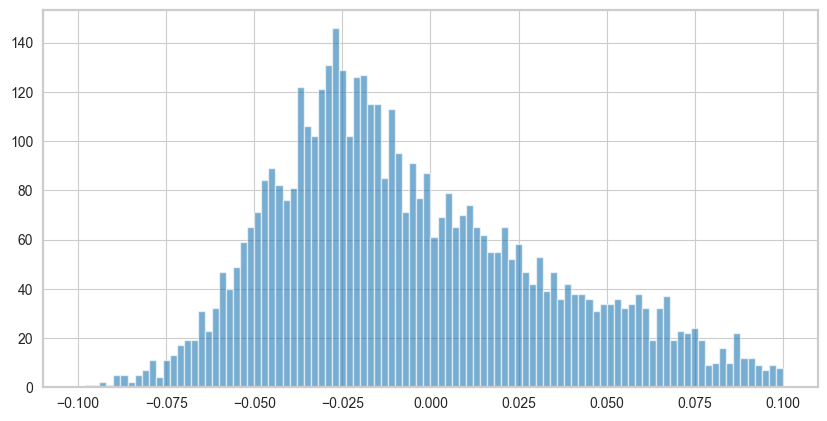

-0.010665007401257753


In [13]:
plt_kwargs = {'bins': 100,
              'range': (-0.1, 0.1),
              'alpha': 0.6}

plt.hist(pnl_before, **plt_kwargs)
plt.show()

print(get_reward(pnl_before))

In [14]:
losses = learn(model, env, steps=150)

Loss=0.00273: 100%|██████████| 150/150 [00:46<00:00,  3.24it/s]


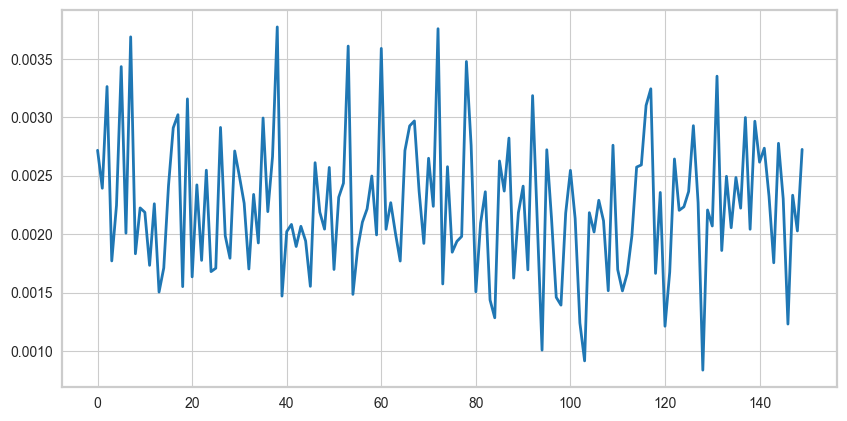

In [15]:
plt.plot(losses)

In [89]:
with th.no_grad():
    pnl_after = pnl_eval(model, eval_env)

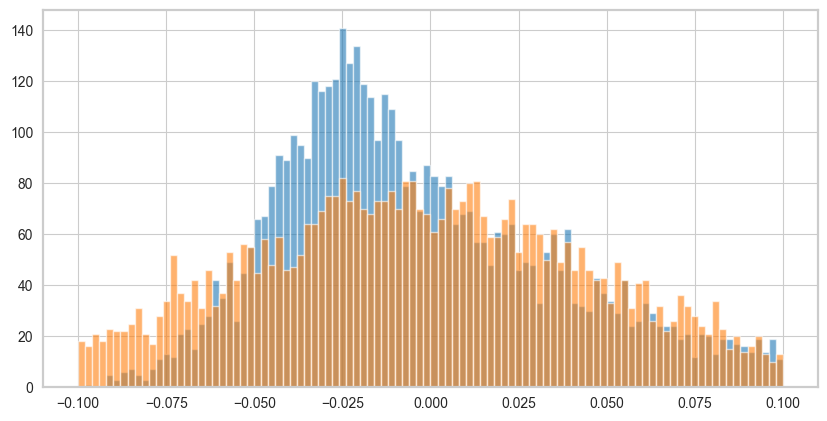

-0.009800402773544192
-0.012420980795286597


In [90]:
plt.hist(pnl_before, **plt_kwargs)
plt.hist(pnl_after, **plt_kwargs)
plt.show()

print(get_reward(pnl_before))
print(get_reward(pnl_after))